In [67]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression


d:\github\ripple_heterogeneity


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\project_log'

In [3]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat


In [4]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
df = df.loc[df['basepath'].str.contains("GrosmarkAD", case=False)]
df

,Var1,basepath,basename
97,97,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013,Achilles_10252013
98,98,Z:\Data\GrosmarkAD\Achilles\Achilles_11012013,Achilles_11012013
99,99,Z:\Data\GrosmarkAD\Buddy\Buddy_06272013,Buddy_06272013
100,100,Z:\Data\GrosmarkAD\Cicero\Cicero_09012014,Cicero_09012014
101,101,Z:\Data\GrosmarkAD\Cicero\Cicero_09102014,Cicero_09102014
102,102,Z:\Data\GrosmarkAD\Cicero\Cicero_09172014,Cicero_09172014
103,103,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08022013,Gatsby_08022013
104,104,Z:\Data\GrosmarkAD\Gatsby\Gatsby_08282013,Gatsby_08282013


In [5]:
basepath = df.basepath.iloc[0]
cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

In [6]:
# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object), fs=fs_dat)

# behavioral epochs
behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
                                                    data['epochs'].stopTime]).T])

                                                    
                                                    
restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")))

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

# get ripple epochs
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
unit_mat = get_participation(st_unit[behavioral_epochs[1]][ripple_epochs],ripple_epochs[behavioral_epochs[1]])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


<AxesSubplot:>

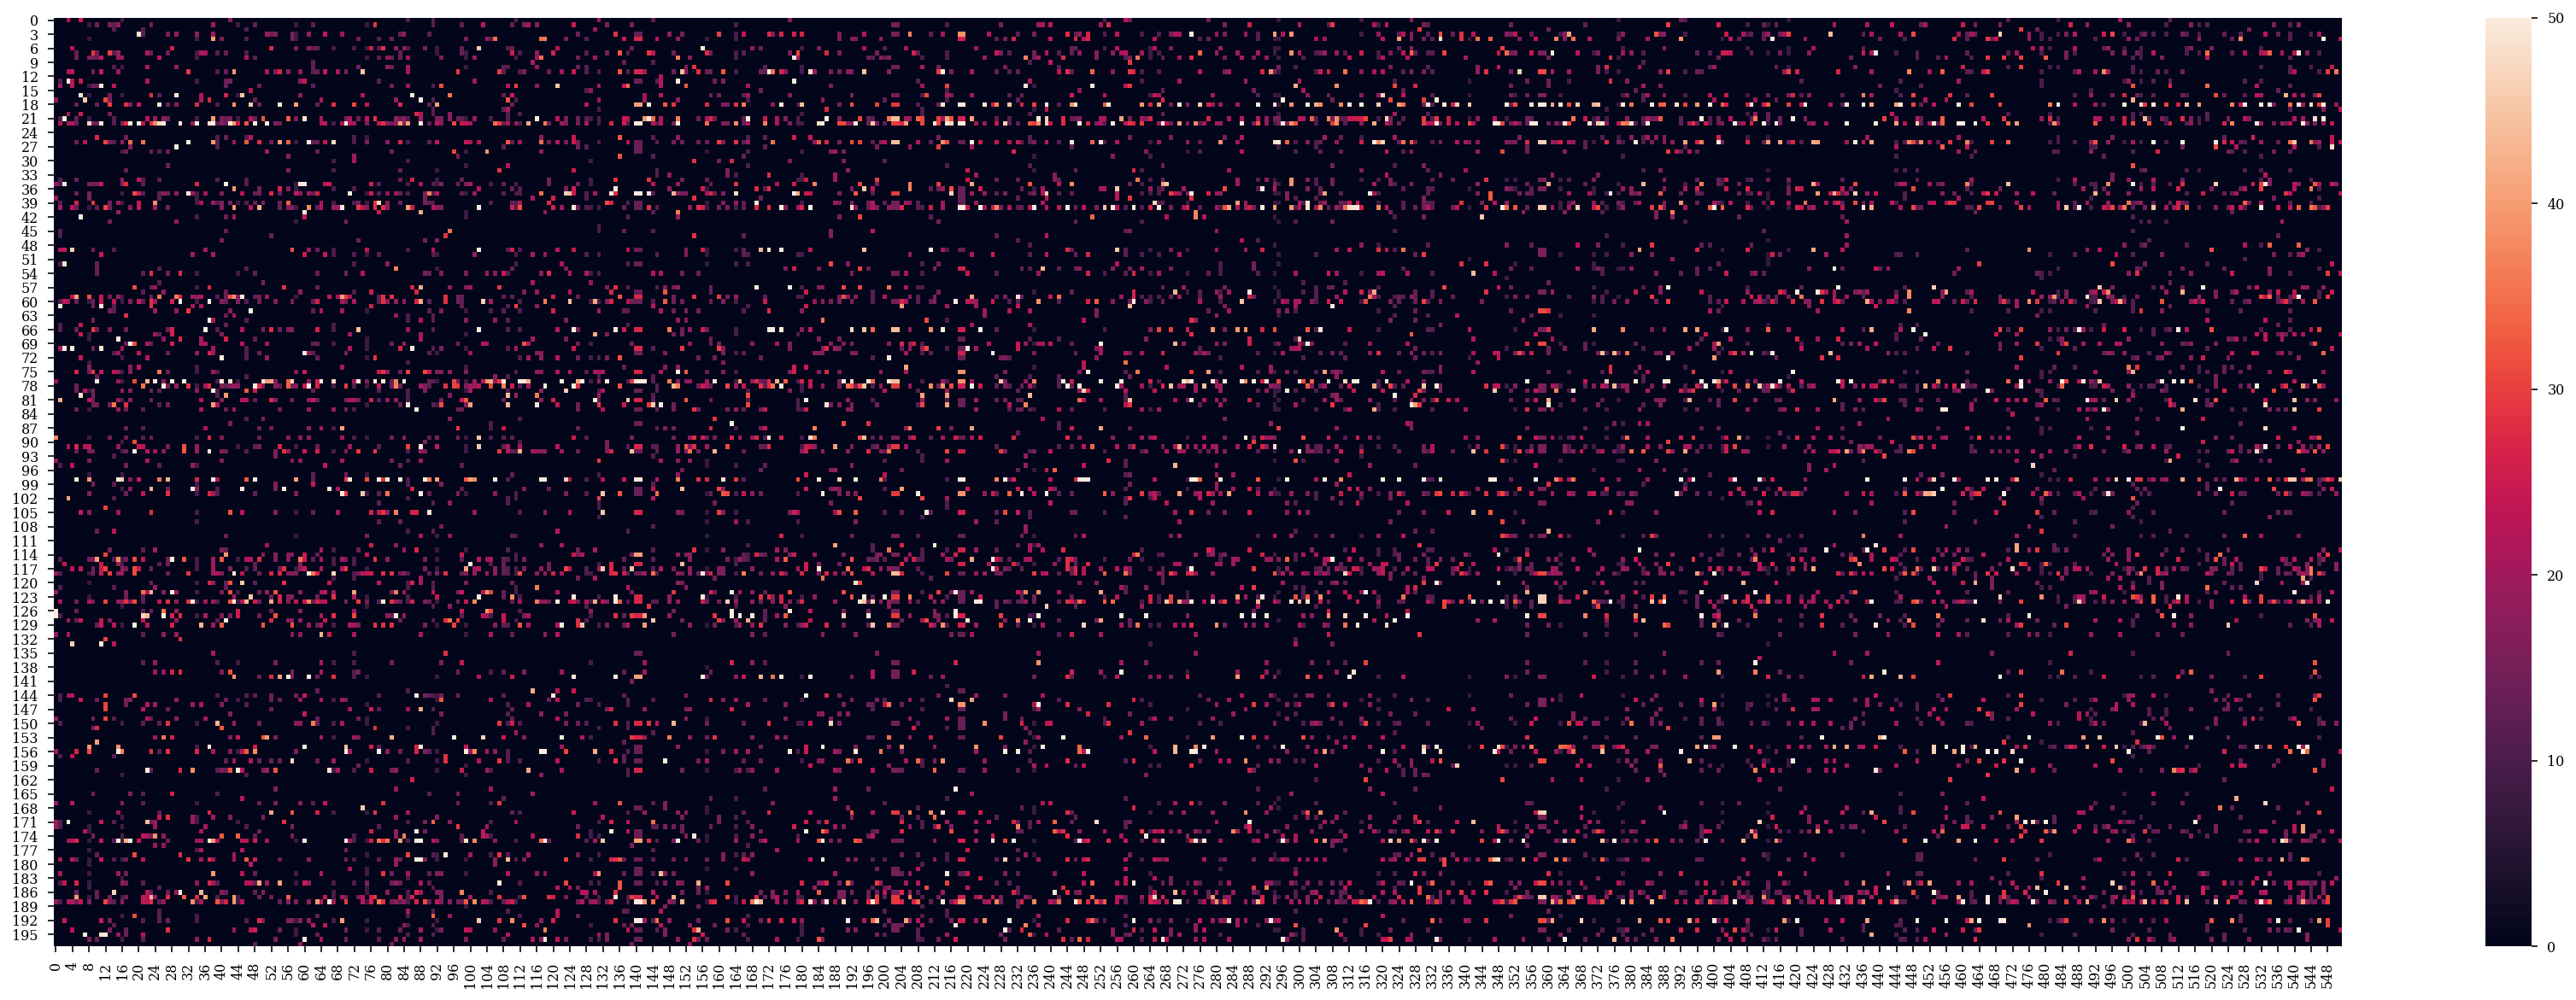

In [8]:
plt.figure(figsize=(30,10))
sns.heatmap(unit_mat,vmax=50)

<AxesSubplot:>

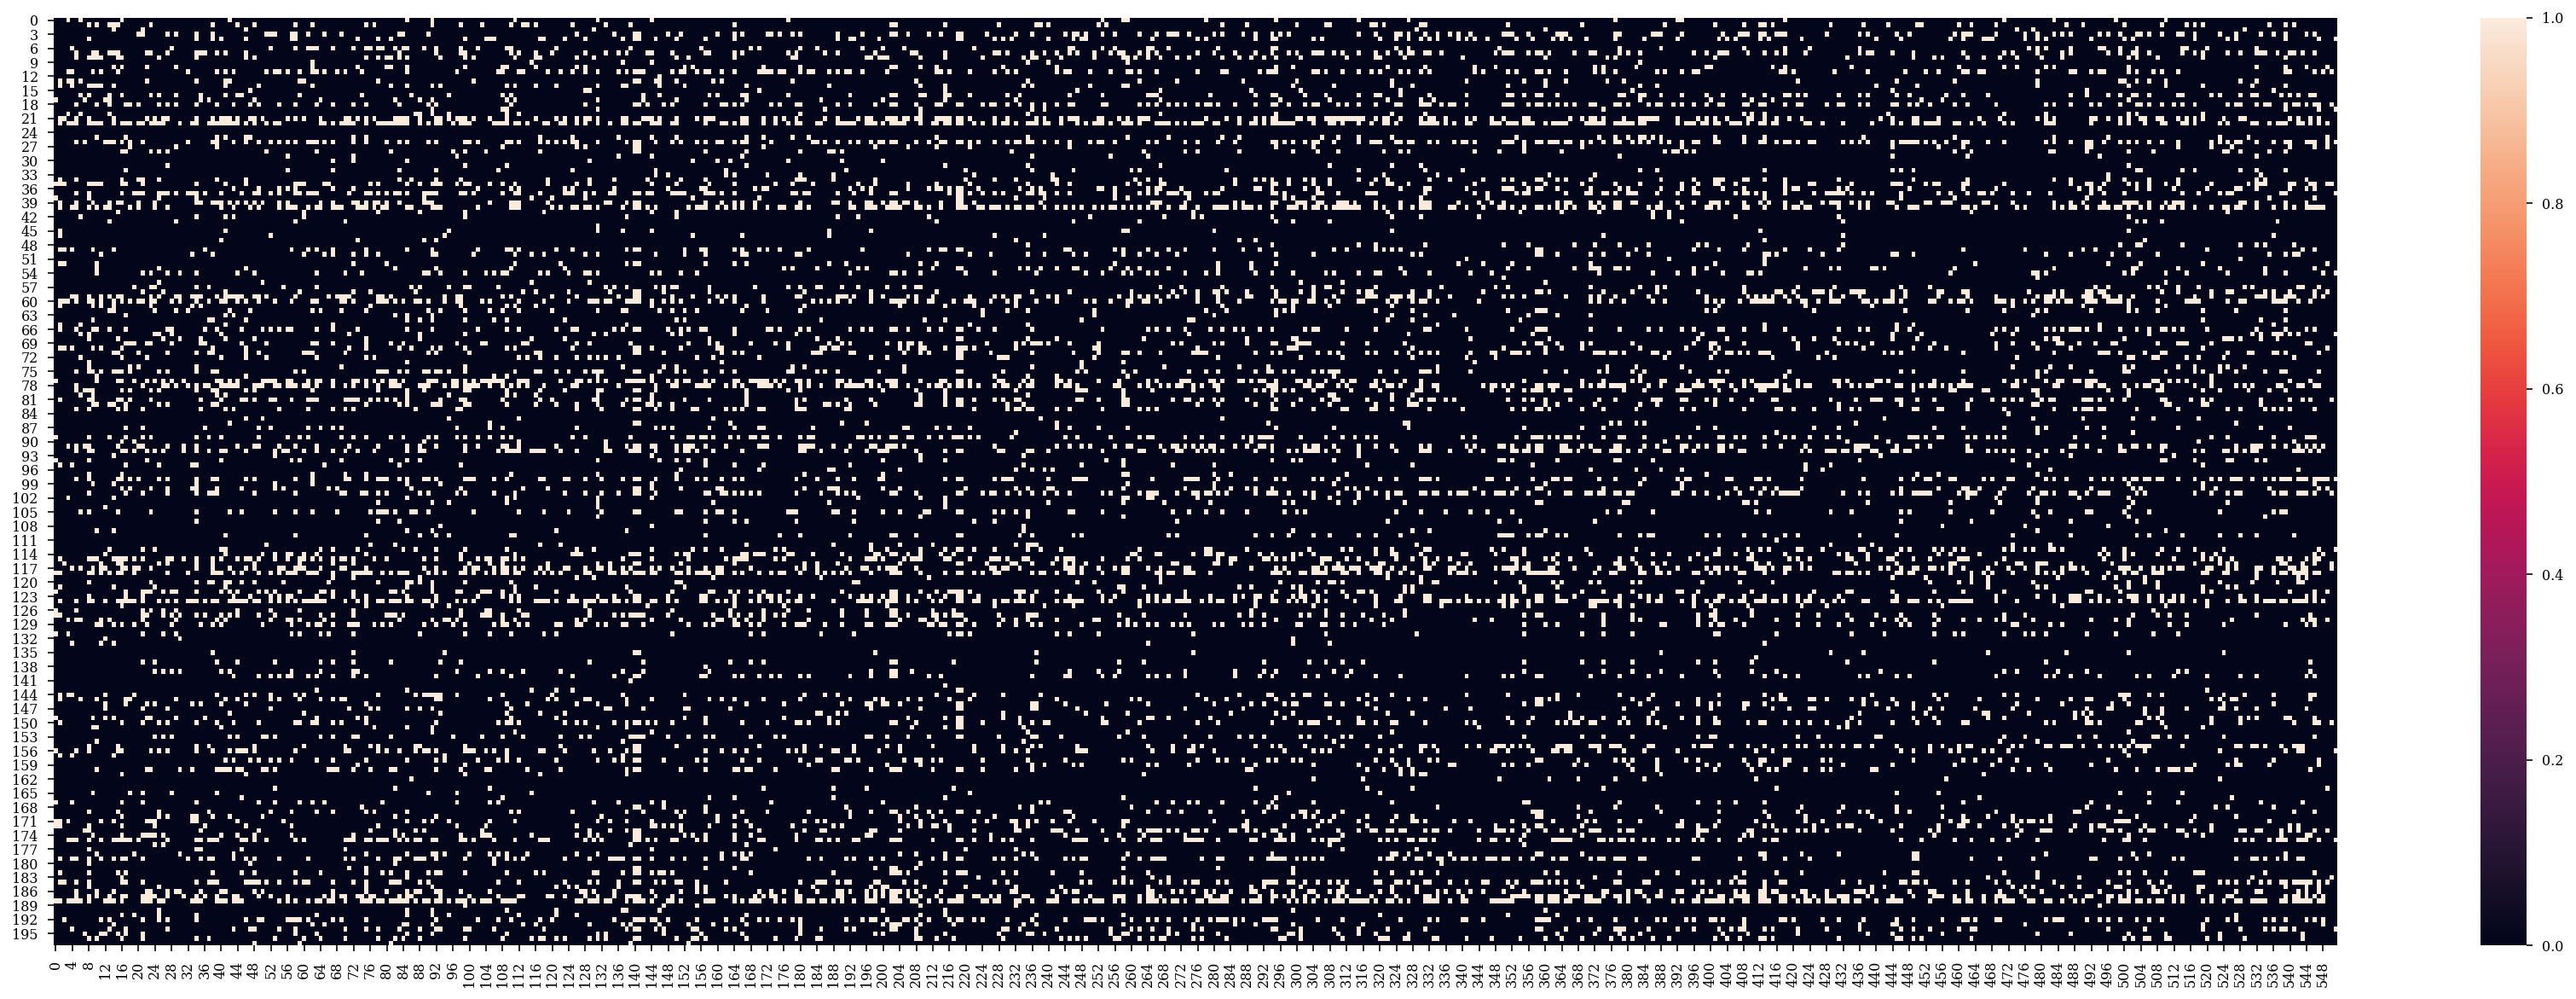

In [10]:
unit_mat_binary = (unit_mat > 0)*1

plt.figure(figsize=(30,10))
sns.heatmap(unit_mat_binary)

In [16]:
participation_prob = np.sum(unit_mat_binary,axis=1) / unit_mat_binary.shape[1]
pop_participation_prob = np.sum(unit_mat_binary,axis=0) / unit_mat_binary.shape[0]

# ripple duration is related to pop ripple firing rate 

Text(0, 0.5, 'mean pop ripple FR')

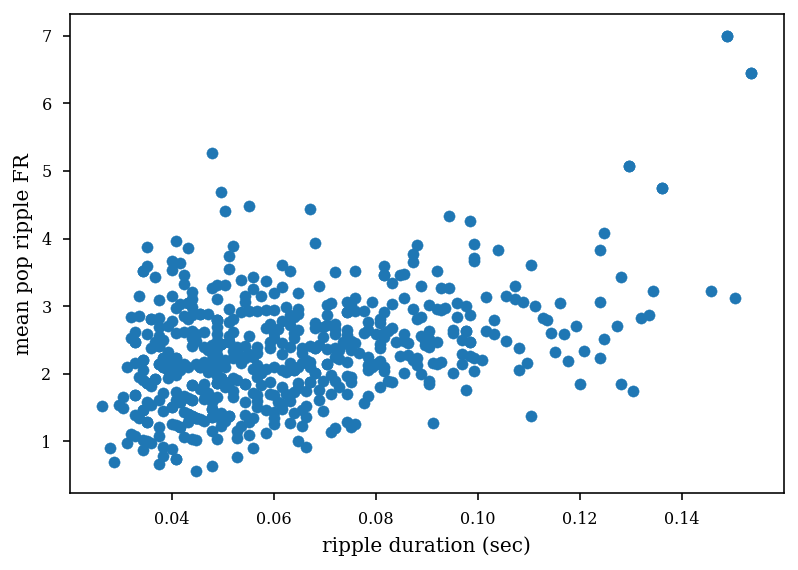

In [17]:
plt.scatter(ripple_epochs[behavioral_epochs[1]].lengths,unit_mat.mean(axis=0))
plt.xlabel('ripple duration (sec)')
plt.ylabel('mean pop ripple FR')


# ripple duration largely predicts population participation

Text(0, 0.5, 'pop participation prob.')

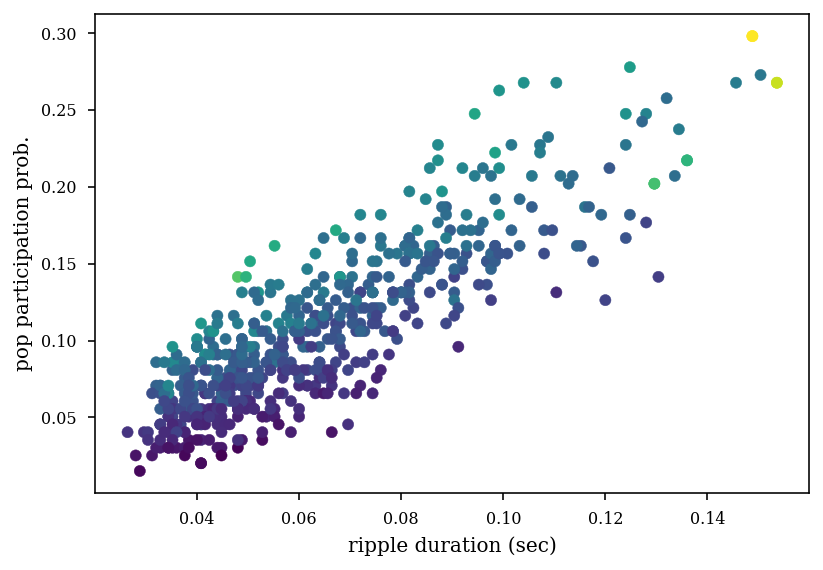

In [20]:
plt.scatter(ripple_epochs[behavioral_epochs[1]].lengths,pop_participation_prob,c=unit_mat.mean(axis=0))
plt.xlabel('ripple duration (sec)')
plt.ylabel('pop participation prob.')

# ripple duration is not related to ripple to ripple lag time

Text(0, 0.5, 'ripple to ripple lag (sec)')

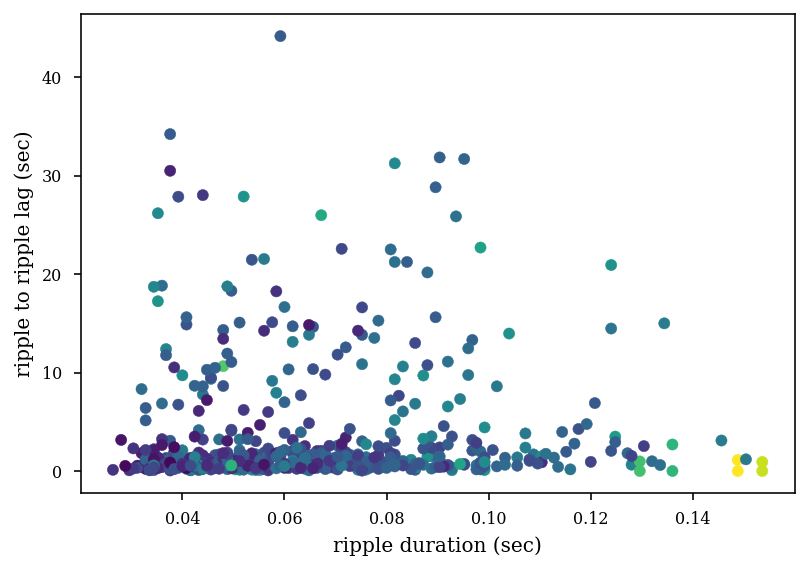

In [35]:
plt.scatter(ripple_epochs[behavioral_epochs[1]].lengths[1:], np.diff(ripple_epochs[behavioral_epochs[1]].starts),c=unit_mat.mean(axis=0)[1:])
# plt.yscale("log")

plt.xlabel('ripple duration (sec)')
plt.ylabel('ripple to ripple lag (sec)')

# It appears that ripple duration remains stable over the session 

Text(0, 0.5, 'ripple duration (sec)')

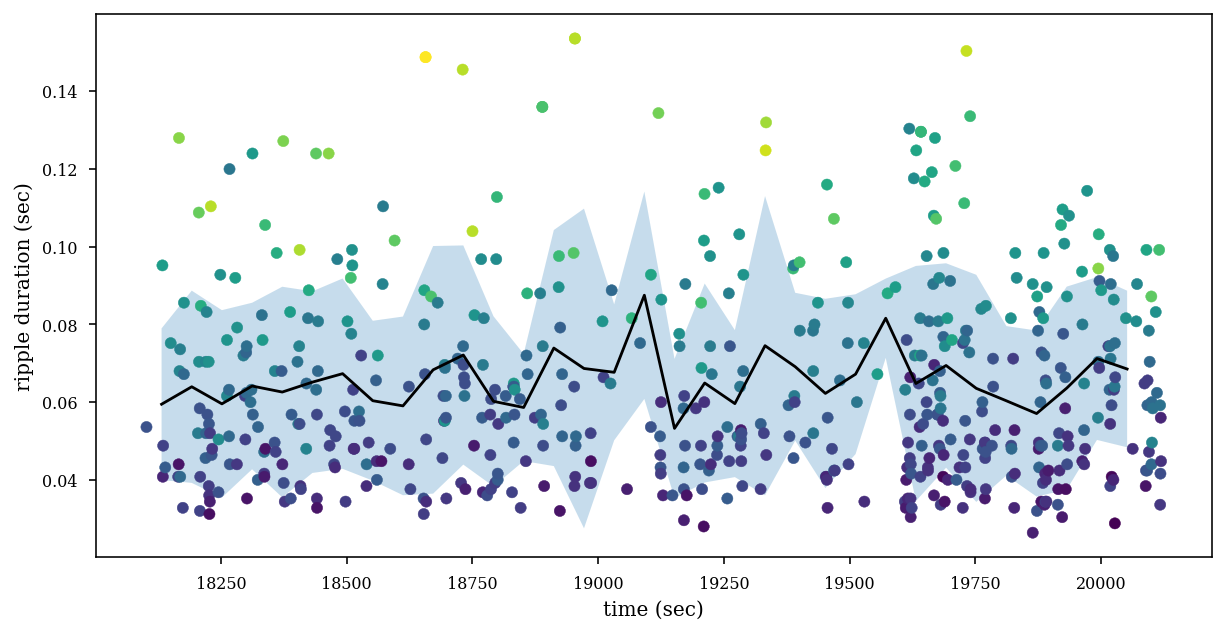

In [64]:
t = ripple_epochs[behavioral_epochs[1]].starts
dur = ripple_epochs[behavioral_epochs[1]].lengths

bin_width = 60
bins = np.arange(t.min(),t.max(),bin_width)
avg_dur = []
std_dur = []
for i in range(bins.shape[0]-1):
    idx = (t >= bins[i]) & (t<=bins[i+1])
    avg_dur.append(dur[idx].mean())
    std_dur.append(dur[idx].std())
avg_dur = np.array(avg_dur)
std_dur = np.array(std_dur)

plt.figure(figsize=(10,5))
plt.fill_between(bins[0:-1]+bin_width/2,avg_dur-std_dur,avg_dur+std_dur,alpha=.25)
plt.scatter(ripple_epochs[behavioral_epochs[1]].starts,ripple_epochs[behavioral_epochs[1]].lengths,c=pop_participation_prob)
plt.plot(bins[0:-1]+bin_width/2, avg_dur,color="k")

plt.xlabel('time (sec)')
plt.ylabel('ripple duration (sec)')

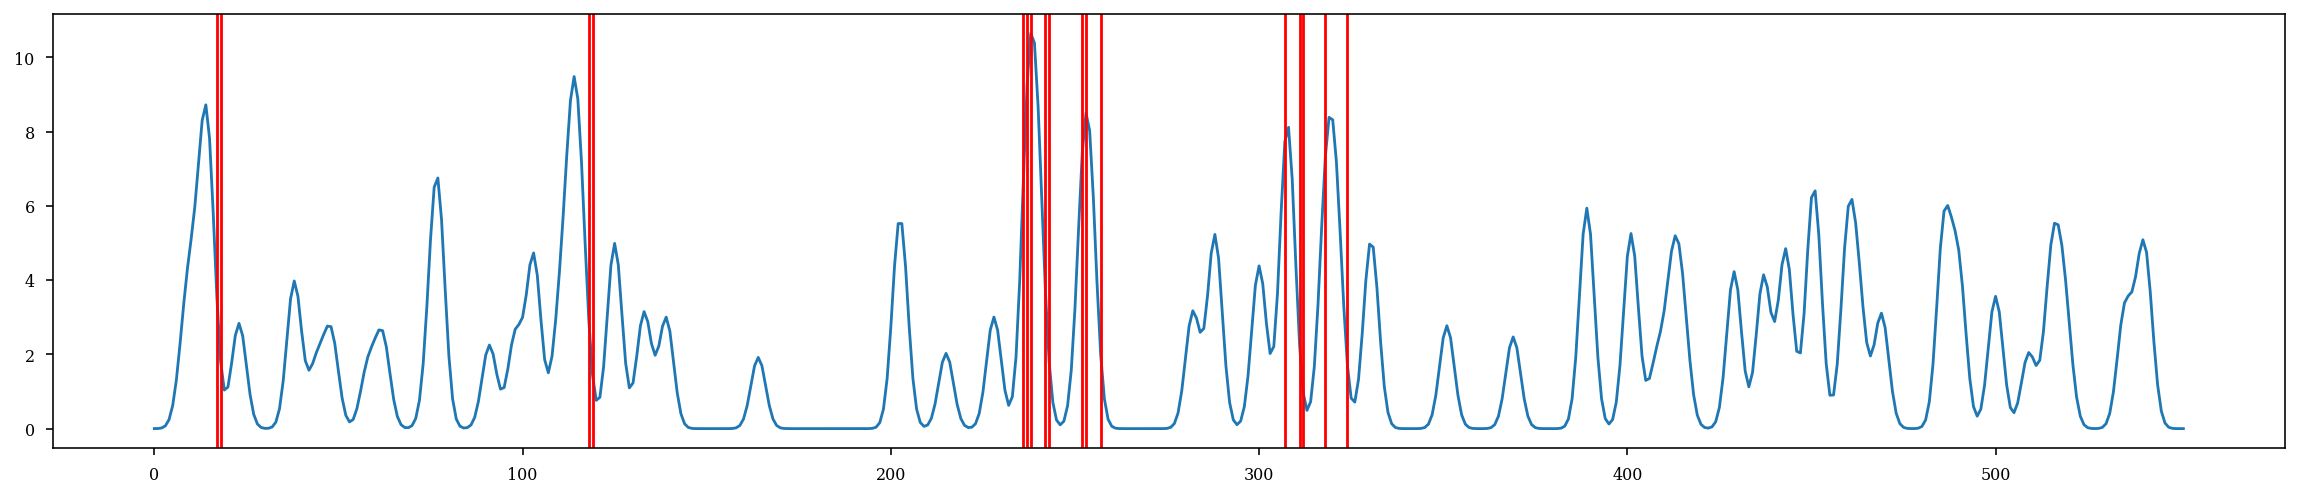

In [199]:
# temp_unit_mat = unit_mat.copy()
# temp_unit_mat[temp_unit_mat==0] = np.nan
# unit_mat_sm = gaussian_filter1d_nan(temp_unit_mat,sigma=2)

unit_mat_sm = gaussian_filter1d_nan(unit_mat,2)

a = np.array(unit_mat_sm[1,:])
b = a[1:] - a[:-1]  
v = abs(b) > 2
edges = v.nonzero()[0] 
edges += 2  
edges

plt.figure(figsize=(20,4))
plt.plot(a)
for e in edges:
    plt.axvline(e,color='r')

(array([  1,  17,  96, 106, 111, 137, 140, 141, 177, 178, 214, 249],
      dtype=int64),)


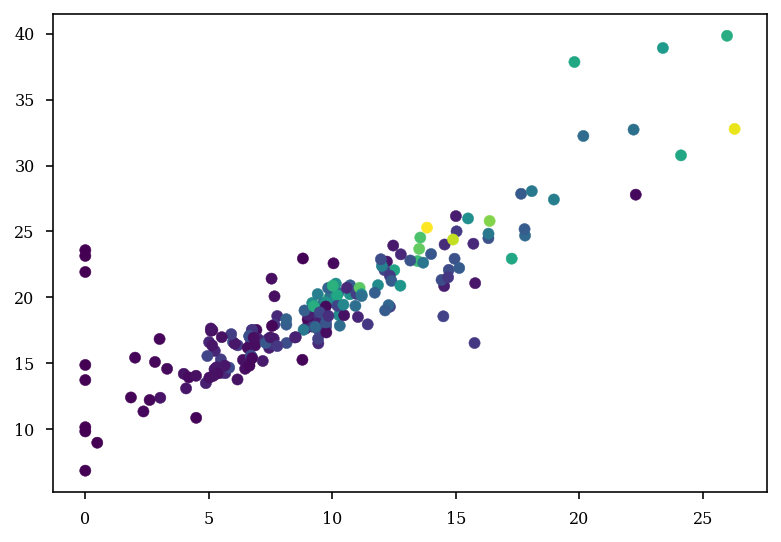

In [193]:
# np.std(unit_mat[unit_mat>0],axis=1)
# unit_mat>0
std_unit = [np.std(u[u>0]) for u in unit_mat]
mean_unit = [np.mean(u[u>0]) for u in unit_mat]

# plt.hist(std_unit,50)
# plt.show()

print(np.where(np.array(std_out)>20))

# print(cell_metrics.putativeCellType.iloc[np.array(std_unit)>20])

plt.scatter(std_unit,mean_unit,c=participation_prob)

In [159]:
def gaussian_filter1d_nan(X,sigma=1):
    X_out = X.copy()
    for i,x in enumerate(X_out):
        valid_idx = ~np.isnan(x)
        
        X_out[i,valid_idx] = gaussian_filter1d(x[valid_idx],sigma)
    return X_out

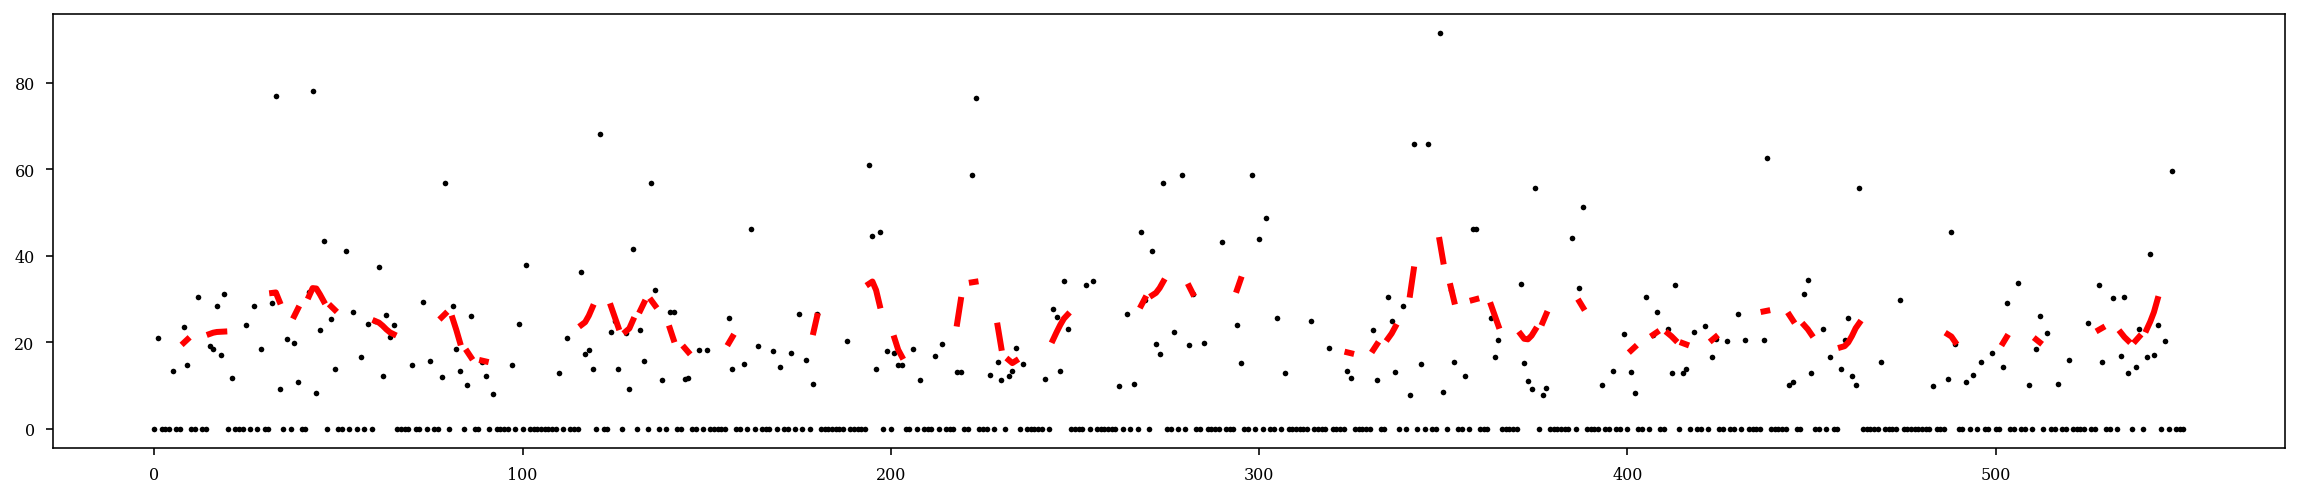

In [188]:
temp_unit_mat = unit_mat.copy()
temp_unit_mat[temp_unit_mat==0] = np.nan
unit_mat_sm = gaussian_filter1d_nan(temp_unit_mat,sigma=2)


plt.figure(figsize=(20,4))
plt.plot(unit_mat[124,:],'.k')
plt.plot(unit_mat_sm[124,:],color="r",linewidth=3)

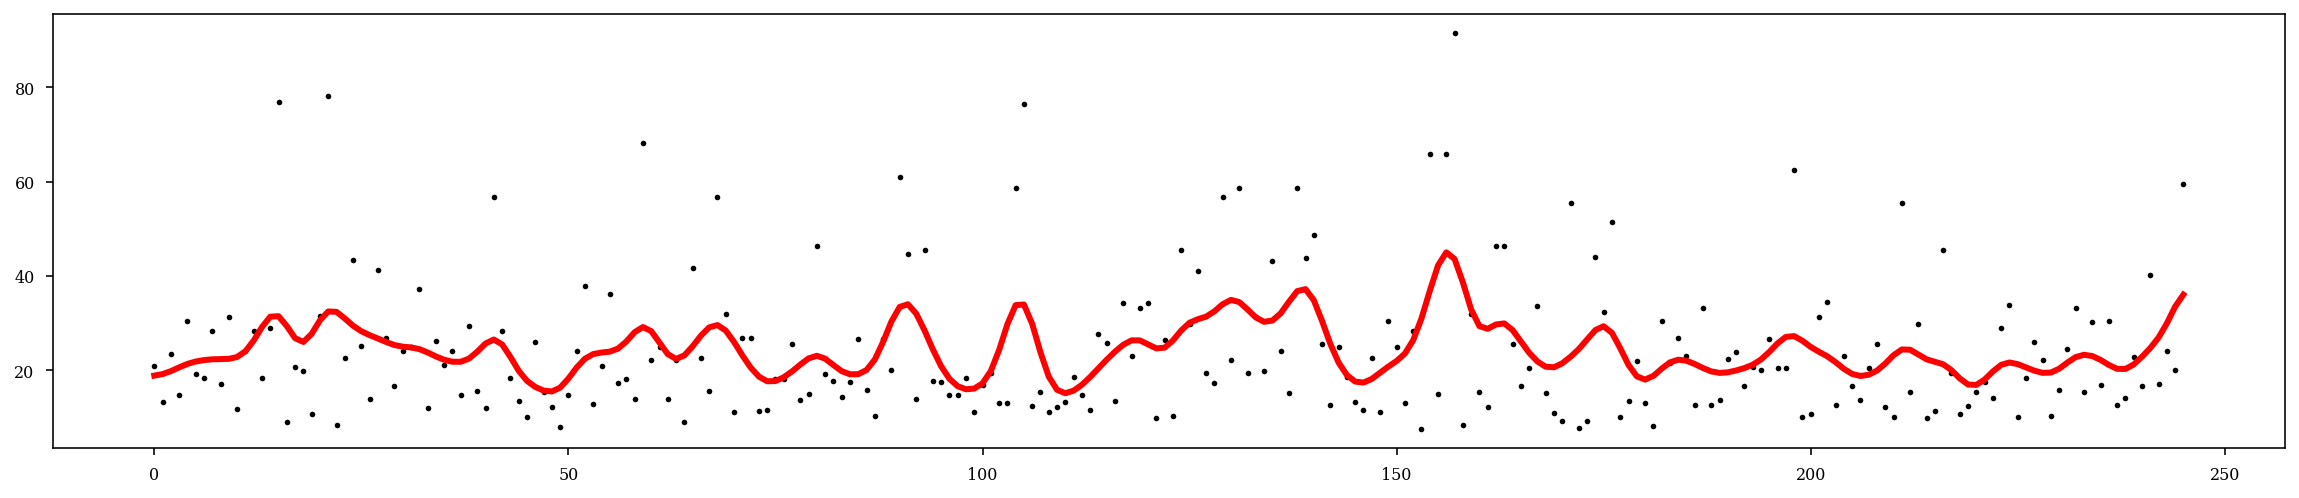

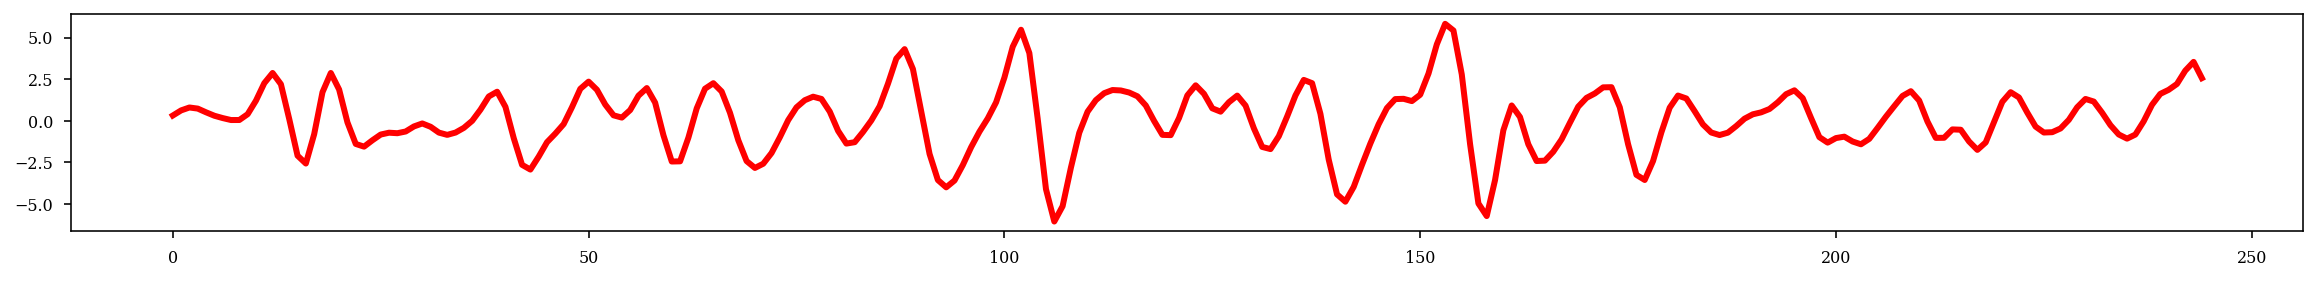

In [190]:
x = unit_mat[124,:]
x = x[x>0]
plt.figure(figsize=(20,4))
plt.plot(x,'.k')
plt.plot(gaussian_filter1d(x,2),color="r",linewidth=3)

plt.figure(figsize=(20,2))
plt.plot(np.diff(gaussian_filter1d(x,2)),color="r",linewidth=3)


<AxesSubplot:>

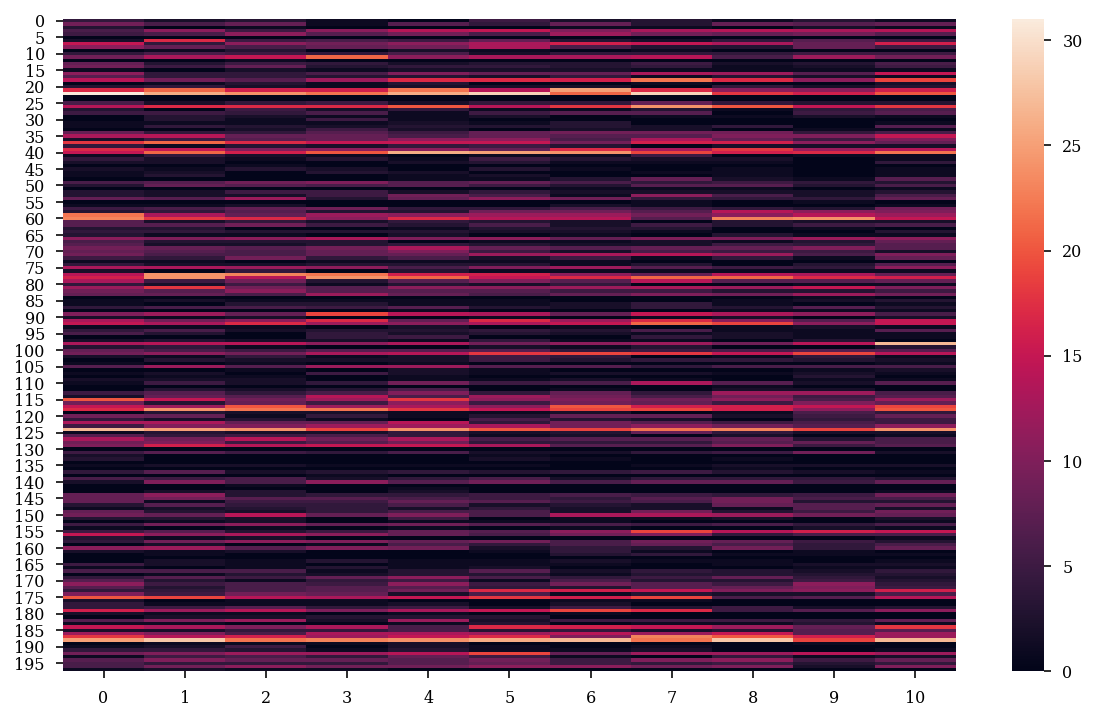

In [65]:
# plt.figure(figsize=(20,4))

# plt.plot(unit_mat[0,:])

unit_mat_binary = (unit_mat > 0)*1

# plt.figure(figsize=(20,4))
# plt.plot(unit_mat_binary[0,:])

bins = np.arange(0,unit_mat_binary.shape[1],50)

unit_mat_binary_sum = []
for i in range(len(bins)-1):
    unit_mat_binary_sum.append(unit_mat_binary[:,bins[i]:bins[i+1]].sum(axis=1))

unit_mat_binary_sum = np.vstack(unit_mat_binary_sum).T

plt.figure(figsize=(10,6))
sns.heatmap(unit_mat_binary_sum)

0.46182266009852213


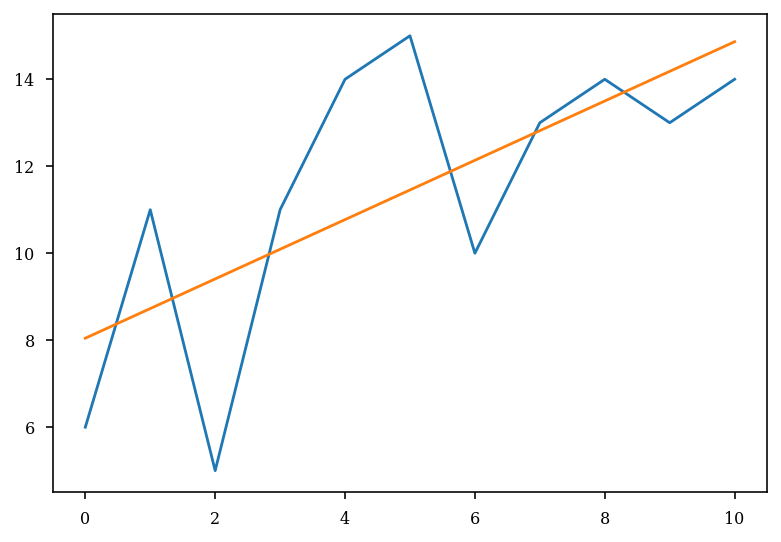

In [289]:

X = np.arange(0,unit_mat_binary_sum.shape[1])
X = np.expand_dims(X, axis=1)
y = unit_mat_binary_sum[3]

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
plt.plot(X,y)

plt.plot(X,X*reg.coef_+reg.intercept_)
plt.show()
# plt.plot(unit_mat_binary_sum[30,:])

In [69]:
X = np.arange(0,unit_mat_binary_sum.shape[1])
X = np.expand_dims(X, axis=1)
r2 = []
b = []
intercept = []
for y in unit_mat_binary_sum:
    reg = LinearRegression().fit(X, y)
    r2.append(reg.score(X, y))
    b.append(reg.coef_[0])
    intercept.append(reg.intercept_)



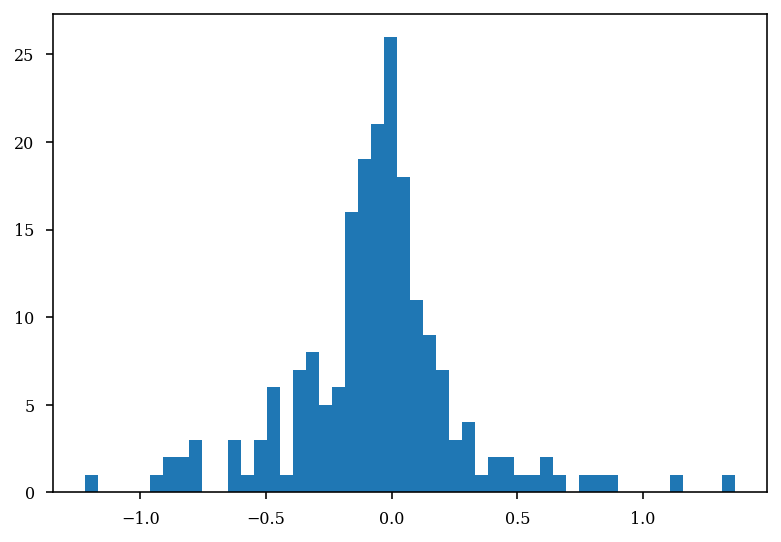

In [72]:
plt.hist(b,50)
plt.show()

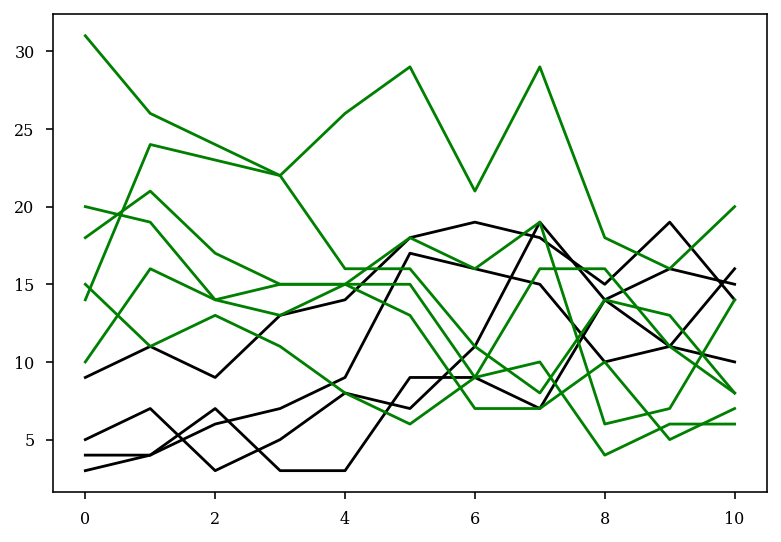

In [74]:
plt.plot(unit_mat_binary_sum[np.array(b)>0.8].T,color='k')
plt.plot(unit_mat_binary_sum[np.array(b)<-0.8].T,color='g')

plt.show()

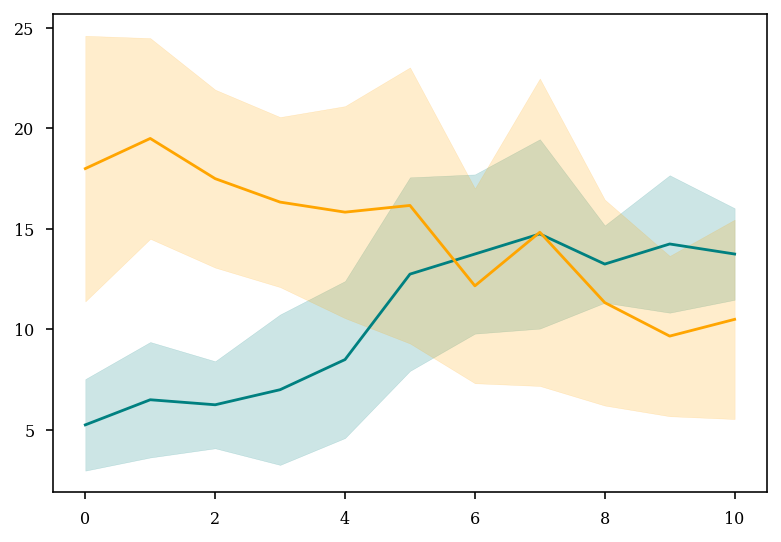

In [75]:
x = unit_mat_binary_sum[np.array(b)>0.8]
plt.plot(np.mean(x,axis=0),color="teal")
plt.fill_between(np.arange(0,len(np.mean(x,axis=0))),
                np.mean(x,axis=0)-np.std(x,axis=0),
                np.mean(x,axis=0)+np.std(x,axis=0),
                alpha=.2,zorder=-100,color="teal")

x = unit_mat_binary_sum[np.array(b)<-0.8]
plt.plot(np.mean(x,axis=0),color="orange")
plt.fill_between(np.arange(0,len(np.mean(x,axis=0))),
                np.mean(x,axis=0)-np.std(x,axis=0),
                np.mean(x,axis=0)+np.std(x,axis=0),
                alpha=.2,zorder=-100,color="orange")

<AxesSubplot:>

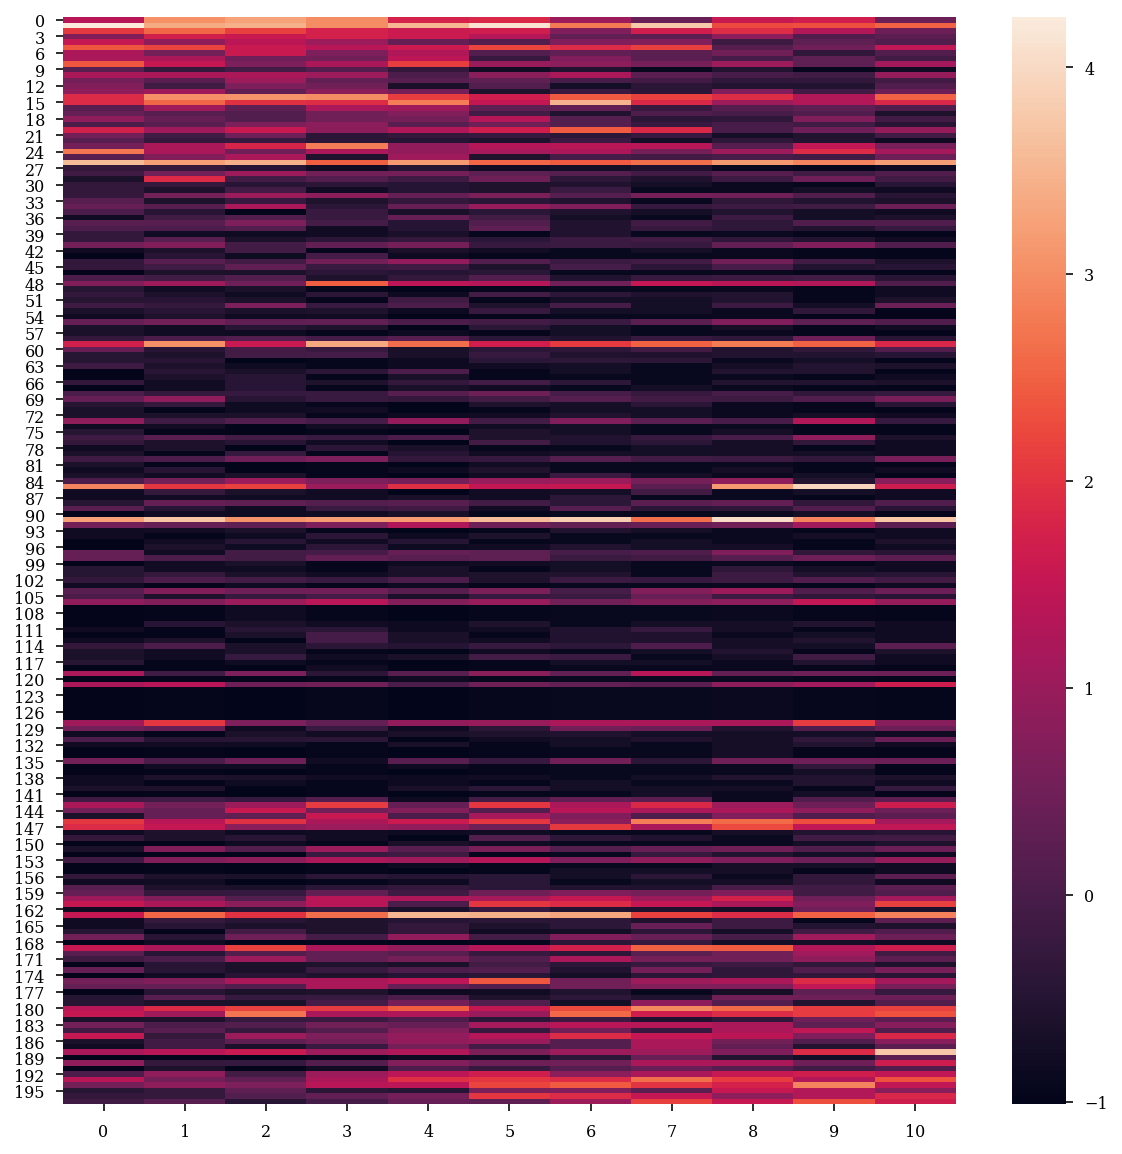

In [76]:
plt.figure(figsize=(10,10))
idx = np.argsort(b)
sns.heatmap(stats.zscore(unit_mat_binary_sum[idx],axis=0))

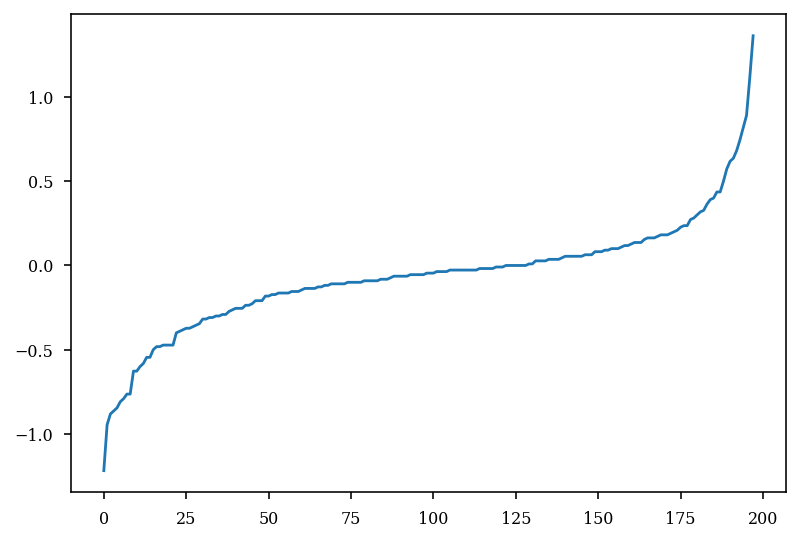

In [295]:
plt.plot(np.sort(b))

Narrow Interneuron
Narrow Interneuron


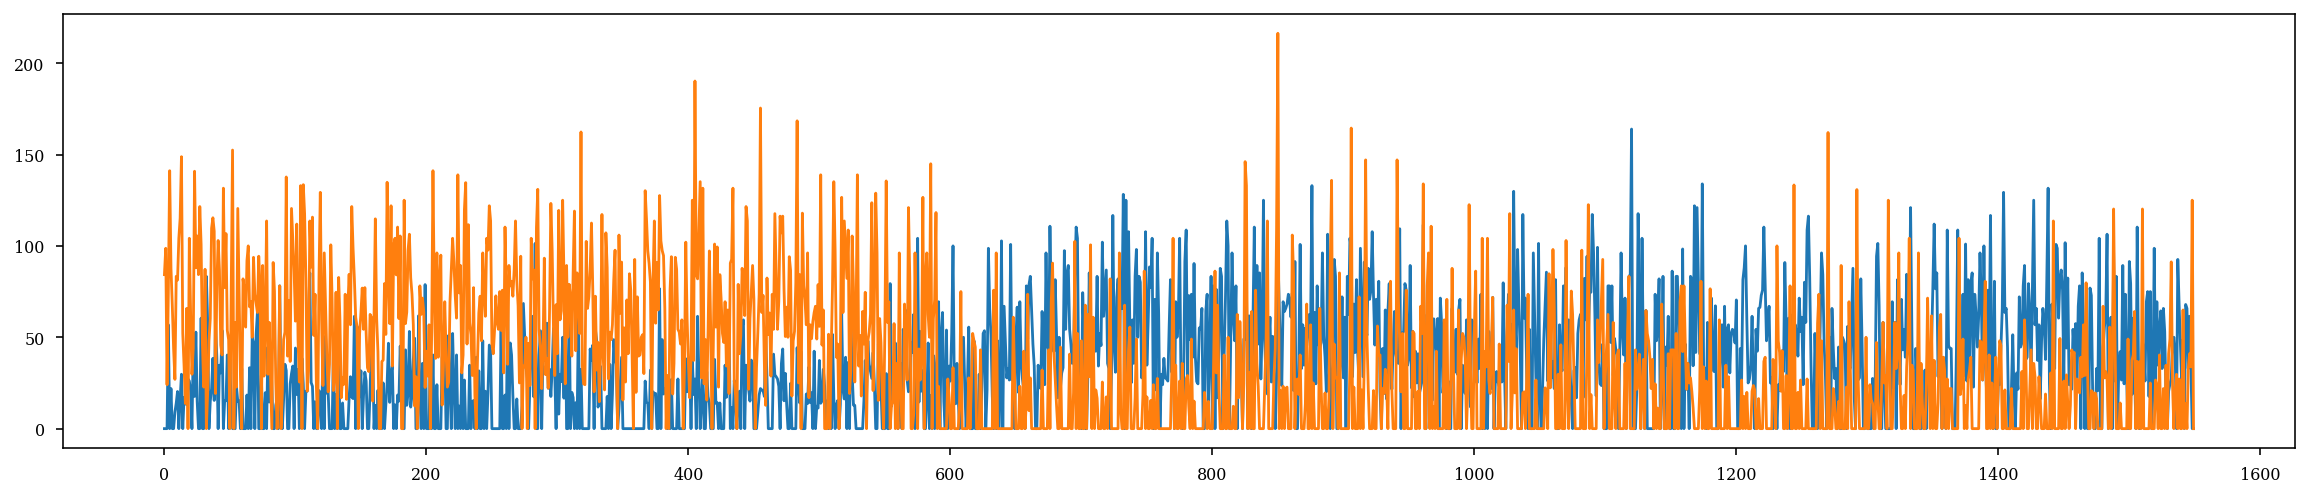

In [12]:
plt.figure(figsize=(20,4))

plt.plot(unit_mat[74,:])
plt.plot(unit_mat[30,:])

print(cell_metrics.putativeCellType.iloc[74])
print(cell_metrics.putativeCellType.iloc[30])
